# Node classification with Node2Vec


In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph #feel free to use any other library of your choice
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)
print(G.info())



StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


node2vec:

In [ ]:
# walks = get random walks using BiasedRandomWalk
#experiment with the hyperparamenters 
walks = BiasedRandomWalk(G)
weighted_walks = walks.run(
    nodes=G.nodes(),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 24850


In [ ]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in weighted_walks ]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1) #check which parameter are important

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["19231"].shape

(128,)

visualize

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
print(node_ids)
#for 
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

['35', '6213', '1365', '3229', '910', '114', '3231', '4330', '19621', '6214', '2440', '1272', '4584', '24966', '2665', '887', '8224', '12576', '20193', '643221', '22563', '12182', '82920', '10169', '3191', '12350', '15429', '31353', '2658', '8703', '39890', '2696', '16819', '35922', '210871', '4804', '23738', '1688', '230879', '39127', '2653', '6334', '3220', '85352', '5086', '5348', '10177', '642894', '54129', '1481', '34257', '4335', '35061', '117', '10796', '6910', '35797', '5064', '153063', '20601', '54131', '41714', '3218', '22229', '79809', '108047', '28287', '3233', '89547', '36140', '205196', '65074', '28350', '2654', '3192', '56115', '18777', '287787', '38205', '17476', '1956', '126927', '46491', '1997', '45605', '45189', '6151', '6184', '10531', '20602', '6913', '162080', '84021', '6163', '3112', '503883', '31489', '23507', '12330', '33818', '77438', '23070', '7532', '56112', '753047', '103515', '14062', '645016', '10798', '7537', '12195', '56119', '3243', '6209', '10183', '1

In [ ]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


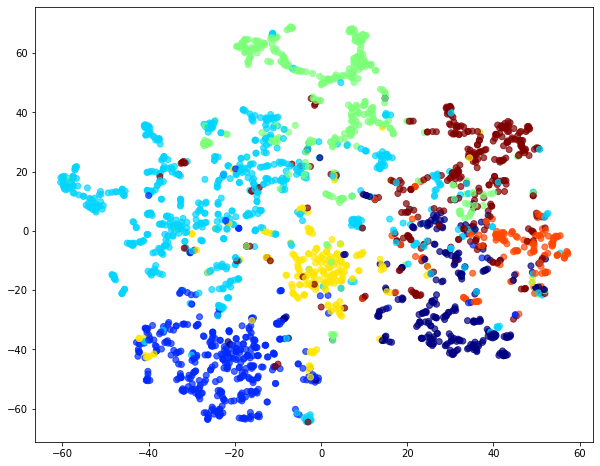

In [ ]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

CORA classification

#Node2Vec Features Classification

In [ ]:
# X will hold the 128-dimensional input features
X = node_embeddings_2d
# y holds the corresponding target values
y = np.array(node_targets)
print(X,y)

y_unique = (np.unique(y))
print(y_unique)
y_temp = np.zeros(y.shape)
for i in range(len(y)):
 y_temp[i] = (np.where(y_unique == y[i])[0])

y1 = y_temp.astype(int)

print(y1)

[[-18.84229    -41.02799   ]
 [ -0.22949935 -16.48205   ]
 [-34.771324     0.43286788]
 ...
 [-21.377777   -42.72099   ]
 [ 15.125082    24.70335   ]
 [-25.24077    -38.538033  ]] ['Genetic_Algorithms' 'Reinforcement_Learning' 'Neural_Networks' ...
 'Genetic_Algorithms' 'Neural_Networks' 'Genetic_Algorithms']
['Case_Based' 'Genetic_Algorithms' 'Neural_Networks'
 'Probabilistic_Methods' 'Reinforcement_Learning' 'Rule_Learning' 'Theory']
[1 4 2 ... 1 2 1]


In [ ]:

#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y1, train_size=0.0564, test_size=None, random_state=42
)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (140, 2)
 y_train = (140,)
 X_test = (2345, 2)
 y_test = (2345,)


In [ ]:
ovo_classifier = OneVsOneClassifier(svm.SVC(random_state=42))
parameters = {'estimator__kernel':['linear'], 'estimator__C':[0.01,0.1,1,10,100, 1000,10000]}
grid_svm_mc = GridSearchCV(ovo_classifier,parameters,cv=5,scoring='accuracy')
grid_svm_mc.fit(X_train, y_train)
pred_ovo_classifier = grid_svm_mc.best_estimator_.predict(X_test)

In [ ]:
# F-1 , Accuracy, Recall and Precision scores
f1 = f1_score(y_test, pred_ovo_classifier, average='macro')
recall = recall_score(y_test, pred_ovo_classifier, average='macro')
accuracy = accuracy_score(y_test, pred_ovo_classifier)
precision = precision_score(y_test, pred_ovo_classifier, average='macro')

In [ ]:
print("The F-1 score is ", f1)
print("The recall score is ", recall)
print("The accuracy score is ", accuracy)
print("The precision score is ", precision)

The F-1 score is  0.7260132830415996
The recall score is  0.7430547357735485
The accuracy score is  0.7428571428571429
The precision score is  0.7212098914593766


#Text Features Calculation

In [ ]:
!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

--2022-05-05 07:33:53--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168052 (164K) [application/x-gzip]
Saving to: ‘cora.tgz.2’

cora.tgz.2          100%[===================>] 164.11K  --.-KB/s    in 0.05s   

2022-05-05 07:33:53 (3.51 MB/s) - ‘cora.tgz.2’ saved [168052/168052]



In [ ]:
!tar -xvf  'cora.tgz' 

cora/
cora/README
cora/cora.cites
cora/cora.content


In [ ]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                

all_data = shuffle(all_data,random_state=42)

In [ ]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
 
    elements = data.split('\t')
    if elements[0] in node_ids: 
      labels.append(elements[-1])
      X.append(elements[1:-1])
      nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] 
F = X.shape[1]
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

print(node_ids, nodes)

X shape:  (2485, 1433)

Number of nodes (N):  2485

Number of features (F) of each node:  1433

Categories:  {'Rule_Learning', 'Reinforcement_Learning', 'Genetic_Algorithms', 'Theory', 'Case_Based', 'Probabilistic_Methods', 'Neural_Networks'}

Number of classes:  7
['35', '6213', '1365', '3229', '910', '114', '3231', '4330', '19621', '6214', '2440', '1272', '4584', '24966', '2665', '887', '8224', '12576', '20193', '643221', '22563', '12182', '82920', '10169', '3191', '12350', '15429', '31353', '2658', '8703', '39890', '2696', '16819', '35922', '210871', '4804', '23738', '1688', '230879', '39127', '2653', '6334', '3220', '85352', '5086', '5348', '10177', '642894', '54129', '1481', '34257', '4335', '35061', '117', '10796', '6910', '35797', '5064', '153063', '20601', '54131', '41714', '3218', '22229', '79809', '108047', '28287', '3233', '89547', '36140', '205196', '65074', '28350', '2654', '3192', '56115', '18777', '287787', '38205', '17476', '1956', '126927', '46491', '1997', '45605', '4

In [ ]:
#TFIDF
#X_tf = []
tf_transformer = TfidfTransformer(use_idf=False).fit(X)
X_tf =tf_transformer.transform(X)
print(X_tf.shape)
labels = np.array(labels)
print(X_tf[0].shape)

(2485, 1433)
(1, 1433)


In [ ]:

#Train test split

X_train_tf, X_test_tf, y_train, y_test = train_test_split( X_tf, labels, train_size=0.0564,  test_size = None, random_state=42 )
X_train_tf =X_train_tf.toarray()
X_test_tf = X_test_tf.toarray()


print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train_tf.shape, y_train.shape, X_test_tf.shape, y_test.shape
    )
)

Array shapes:
 X_train = (140, 1433)
 y_train = (140,)
 X_test = (2345, 1433)
 y_test = (2345,)


In [ ]:
ovo_classifier = OneVsOneClassifier(svm.SVC(random_state=42))
parameters = {'estimator__kernel':['linear'], 'estimator__C':[0.01,0.1,1,10,100, 1000,10000]}
grid_svm_mc = GridSearchCV(ovo_classifier,parameters,cv=5,scoring='accuracy')
grid_svm_mc.fit(X_train_tf, y_train)
pred_ovo_classifier = grid_svm_mc.best_estimator_.predict(X_test_tf)

In [ ]:
# F-1 , Accuracy, Recall and Precision scores
f1 = f1_score(y_test, pred_ovo_classifier, average='macro')
recall = recall_score(y_test, pred_ovo_classifier, average='macro')
accuracy = accuracy_score(y_test, pred_ovo_classifier)
precision = precision_score(y_test, pred_ovo_classifier, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("The F-1 score is ", f1)
print("The recall score is ", recall)
print("The accuracy score is ", accuracy)
print("The precision score is ", precision)

The F-1 score is  0.5326957112442786
The recall score is  0.5206613542349231
The accuracy score is  0.6260127931769722
The precision score is  0.5817201068087215


#





































































































































#Classification using Combined Features

In [ ]:
print(X_train.shape, X_train_tf.shape)
X_train_comb = np.column_stack((X_train, X_train_tf))
X_test_comb = np.column_stack((X_test, X_test_tf))



(140, 2) (140, 1433)
(140, 2) (140, 1433)
[0. 0. 0. ... 0. 0. 0.]
[-57.91928   16.239985]


In [ ]:
ovo_classifier = OneVsOneClassifier(svm.SVC(random_state=42))
parameters = {'estimator__kernel':['linear'], 'estimator__C':[0.01,0.1,1,10,100, 1000,10000]}
grid_svm_mc = GridSearchCV(ovo_classifier,parameters,cv=5,scoring='accuracy')
grid_svm_mc.fit(X_train_comb, y_train)
pred_ovo_classifier = grid_svm_mc.best_estimator_.predict(X_test_comb)

In [ ]:
# F-1 , Accuracy, Recall and Precision scores
f1 = f1_score(y_test, pred_ovo_classifier, average='macro')
recall = recall_score(y_test, pred_ovo_classifier, average='macro')
accuracy = accuracy_score(y_test, pred_ovo_classifier)
precision = precision_score(y_test, pred_ovo_classifier, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("The F-1 score is ", f1)
print("The recall score is ", recall)
print("The accuracy score is ", accuracy)
print("The precision score is ", precision)

The F-1 score is  0.5045242731126118
The recall score is  0.4957085211325753
The accuracy score is  0.5961620469083155
The precision score is  0.5488616955318374
